In [1]:
import json
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
import math
%matplotlib inline

Using TensorFlow backend.


In [2]:
import math
import numpy as np
import pandas as pd

class DataLoader():
    '''Class for loading and transforming data for LSTM model'''
    def __init__(self, filename_x, filename_y):
        dataframe_x = pd.read_csv(filename_x, sep='\s+',header=None)
        dataframe_y = pd.read_csv(filename_y, sep='\s+',header=None)
        self.x = dataframe_x.values[:]
        self.y = dataframe_y.values[:]
        self.len = len(self.x)
        self.seq_len = 30

    def get_train_data(self):
        train_x = []
        train_y = []
        train_dim = math.floor(self.len/self.seq_len)
        for i in range(train_dim):
            start = i*self.seq_len
            end = (i+1)*self.seq_len
            train_x.append(self.x[start:end])
            train_y.append(self.y[start:end])
            # print(i*self.seq_len, (i+1)*self.seq_len)
        return np.array(train_x), np.array(train_y)
        
    def get_data(self):
        return np.array(self.x), np.array(self.y)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.x[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)
    
    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [6]:
project_path="./"
save_dir = project_path + "saved_models/dropout_saved_models/"
data_path = project_path + "C1-6/C1-6_CanTho/"
filenames = ["C1", "C2", "C3", "C4"]#, "C5", "C6"]
# filenames = ["C1"]

# neurons = [5,8,10,12,15]
neurons = [15]
optimizers = ['rmsprop', 'adagrad', 'adadelta', 'adam']
# optimizers = ['rmsprop', 'adagrad', 'adadelta']
i = 0

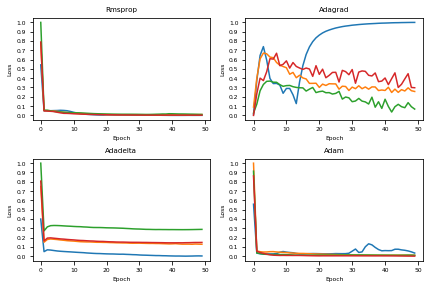

In [7]:
plt.rcParams.update({'font.size': 6})
for neuron in neurons:
    i+=1
    plt.figure(i)    
    splt = 220
    
    for optimizer in optimizers:
        
        splt = splt+1
        plt.subplot(splt)
        datas = []
        for filename in filenames:
            with open(save_dir + str(neuron) + '-' + filename + '-' + optimizer + '-history.json') as f:
                data = json.load(f)
            datas.append(data)
            
        datas = np.array(datas)
        datas = (datas-np.min(datas))/(np.max(datas)-np.min(datas))

#         scaler = MinMaxScaler(feature_range=(0, 1))
#         scaler = scaler.fit(datas)
#         datas = scaler.transform(datas)
        for i in range(datas.shape[0]):
            plt.plot(datas[i])
        plt.yticks(np.arange(0,1.1,0.1))
#         plt.xticks(np.arange(1,50,1))

        plt.title('{}'.format(optimizer.capitalize()))
        plt.ylabel('Loss')
        plt.xlabel('Epoch')

    plt.tight_layout()
    plt.savefig('./plots/23-11/{}-{}.eps'.format(neuron,optimizer), format='eps', dpi=1000)
    plt.show()

[model] 15, C1, rmsprop
R: -0.5763.RMSE: 7011.2605. MAE: 5096.7655. 


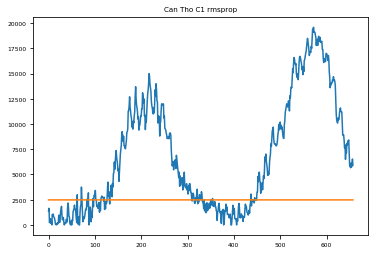

[model] 15, C1, adagrad
R: -0.0674.RMSE: 5769.4896. MAE: 4777.6669. 


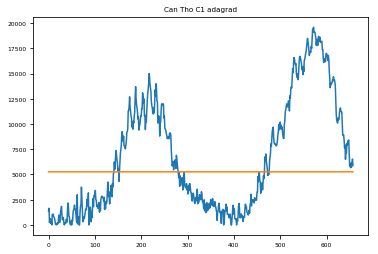

[model] 15, C1, adadelta
R: -0.5703.RMSE: 6997.9077. MAE: 5091.0197. 


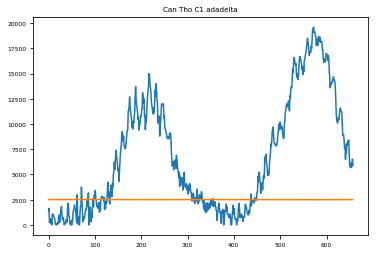

[model] 15, C1, adam
R: -0.5348.RMSE: 6918.4175. MAE: 5052.3747. 


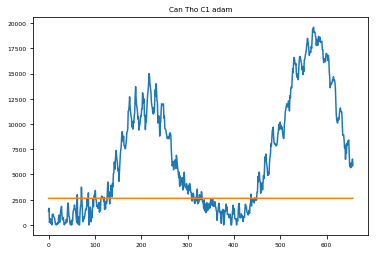

[model] 15, C2, rmsprop
R: -0.5439.RMSE: 6933.9549. MAE: 5063.9683. 


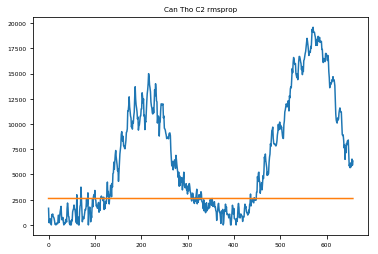

[model] 15, C2, adagrad
R: 0.4432.RMSE: 4163.9534. MAE: 3063.5776. 


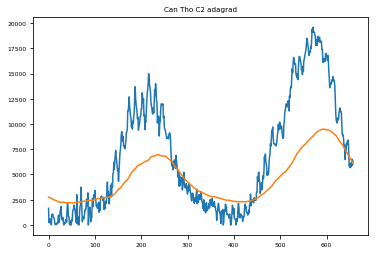

[model] 15, C2, adadelta
R: -0.5385.RMSE: 6921.7814. MAE: 5051.0674. 


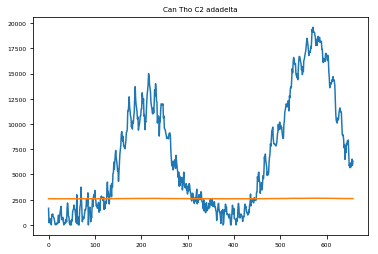

[model] 15, C2, adam
R: -0.4395.RMSE: 6695.3527. MAE: 4966.2943. 


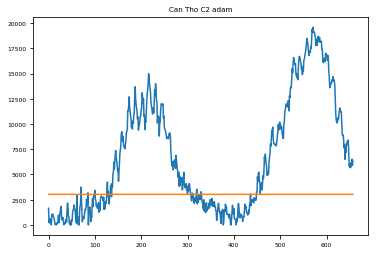

[model] 15, C3, rmsprop
R: -0.565.RMSE: 6981.2162. MAE: 5085.0859. 


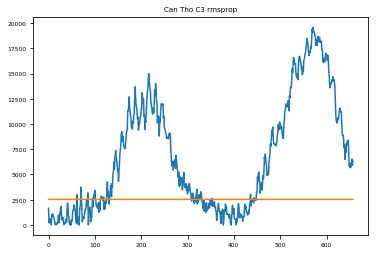

[model] 15, C3, adagrad
R: 0.3647.RMSE: 4447.8597. MAE: 3373.3072. 


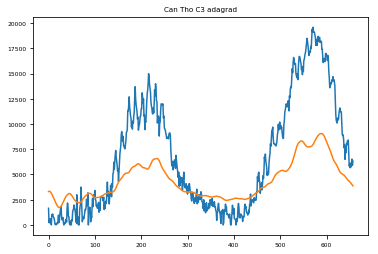

[model] 15, C3, adadelta
R: -0.5448.RMSE: 6936.1414. MAE: 5059.9143. 


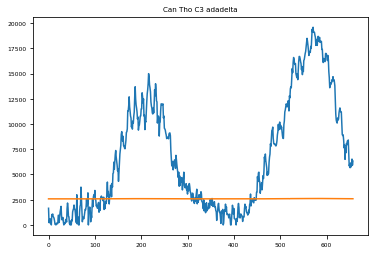

[model] 15, C3, adam
R: -0.4324.RMSE: 6678.9334. MAE: 4960.3081. 


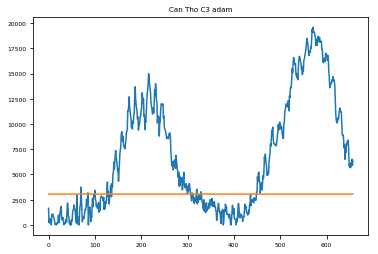

[model] 15, C4, rmsprop
R: -0.5872.RMSE: 7030.5988. MAE: 5110.67. 


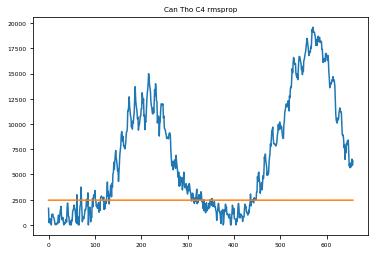

[model] 15, C4, adagrad
R: 0.5808.RMSE: 3613.222. MAE: 2934.816. 


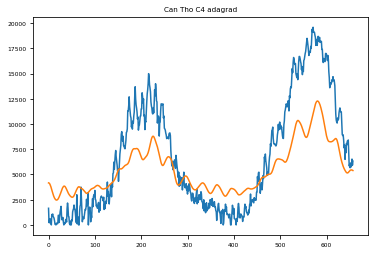

[model] 15, C4, adadelta
R: -0.5536.RMSE: 6955.8448. MAE: 5072.9147. 


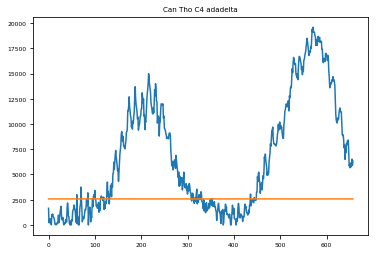

[model] 15, C4, adam
R: -0.4192.RMSE: 6648.189. MAE: 4949.6823. 


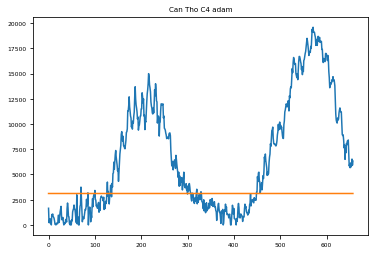

In [8]:
# lstm_model  = load_model('./saved_models_cantho/C1-rmsprop.h5')
i = 0
res_list = []
for filename in filenames:
    for optimizer in optimizers:
        training_data = DataLoader(data_path + filename + "/Training_Input.txt", data_path + filename + "/Training_Target.txt")
        test_data = DataLoader(data_path + filename + "/Testing_Input.txt", data_path + filename + "/Testing_Target.txt")

        x_train, y_train = training_data.get_data()
        x_test, y_test = test_data.get_data()

        train = np.concatenate((x_train, y_train), axis=1)
        test = np.concatenate((x_test, y_test), axis=1)
        scaler, train_scaled, test_scaled = scale(train, test)
#         yhat = invert_scale(scaler, X, yhat)
        neuron_list = []
        for neuron in neurons:
            i+=1
            plt.figure(i)
            print("[model] {}, {}, {}".format(neuron, filename, optimizer))
            lstm_model  = load_model(save_dir + str(neuron) + '-' + filename + '-' + optimizer + '.h5')
            train_reshaped = train_scaled[:, 0:-1].reshape(len(train_scaled), 1, train_scaled.shape[1]-1)
            predict = lstm_model.predict(train_reshaped, batch_size=1)
            #
            predictions = list()
#             predictions = lstm_model.predict(test_scaled[i, 0:-1], batch_size=1)
            for i in range(len(test_scaled)):
                # make one-step forecast
                X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
                yhat = forecast_lstm(lstm_model, 1, X)
                # invert scaling
                yhat = invert_scale(scaler, X, yhat)
                # invert differencing
#                 yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
                # store forecast
                yhat = math.fabs(yhat)
                predictions.append(yhat)
#                 expected = raw_values[len(train) + i + 1]
                expected = y
            
            print("R: {}.RMSE: {}. MAE: {}. ".format(round(r2_score(test[:,-1], predictions),4),
                                                     round(rmse(test[:,-1], predictions),4), 
                                                     round(mean_absolute_error(test[:,-1], predictions),4)))
            neuron_list.append([round(r2_score(test[:,-1], predictions),4),
                                round(rmse(test[:,-1], predictions),4), 
                                round(mean_absolute_error(test[:,-1], predictions),4)])
            plt.plot(test[:, -1])
            plt.plot(predictions)
            plt.title("Can Tho {} {}".format(filename, optimizer))
            plt.show()
        res_list.append(list(map(list, zip(*neuron_list))))



In [33]:
res_list = np.array(res_list).reshape(72,5)
# for i in range(len(res_list)):
#     print(res_list[i])

In [34]:
import pandas as pd
df = pd.DataFrame.from_records(res_list)

In [35]:
df.to_csv('res.csv')